In [8]:
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

- Download and save model to ./local_model, only run this one time

In [ ]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k", num_labels=2)
model.save_pretrained("./local_model")

In [2]:
# Data preparation
dataset = load_dataset("katielink/moleculenet-benchmark", "hiv")
df = pd.DataFrame(dataset['train'])
tokenizer = RobertaTokenizerFast.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

def tokenize_function(examples):
    return tokenizer(examples['smiles'], padding='max_length', truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Save dataset to use load_dataset, use one time only
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)
train_dataset = load_dataset('csv', data_files={'train': 'train.csv'}, split='train')
test_dataset = load_dataset('csv', data_files={'test': 'test.csv'}, split='test')

# Tokenize data and map label
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.map(lambda e: {'labels': e['HIV_active']}, remove_columns=['HIV_active'])
test_dataset = test_dataset.map(lambda e: {'labels': e['HIV_active']}, remove_columns=['HIV_active'])



Using the latest cached version of the dataset since katielink/moleculenet-benchmark couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'hiv' at /home/kyv/.cache/huggingface/datasets/katielink___moleculenet-benchmark/hiv/0.0.0/23379ea3a1886c036f2c75de62433f3d655608ec (last modified on Sun Jun  9 20:44:56 2024).
Generating train split: 26320 examples [00:00, 556562.04 examples/s]
Generating test split: 6580 examples [00:00, 497458.86 examples/s]
Map: 100%|██████████| 6580/6580 [00:00<00:00, 22215.68 examples/s]


In [3]:
# Training params
model = RobertaForSequenceClassification.from_pretrained("./local_model", num_labels=2)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

# AUC and Confusion matrix
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    auc = roc_auc_score(p.label_ids, p.predictions[:, 1])
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': auc
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

/home/kyv/anaconda3/envs/env_capstone/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.119100,0.124038,0.969605,0.382716,0.596154,0.281818,0.792908
2,0.108700,0.126450,0.970517,0.366013,0.651163,0.254545,0.788680
3,0.089200,0.133710,0.970213,0.446328,0.589552,0.359091,0.797749
4,0.058800,0.157481,0.970365,0.462810,0.587413,0.381818,0.799743
5,0.045500,0.176903,0.969301,0.459893,0.558442,0.390909,0.804140


TrainOutput(global_step=8225, training_loss=0.08582842980474686, metrics={'train_runtime': 4175.9026, 'train_samples_per_second': 31.514, 'train_steps_per_second': 1.97, 'total_flos': 1.74327096631296e+16, 'train_loss': 0.08582842980474686, 'epoch': 5.0})

In [4]:
# Save model
model.save_pretrained("./chemberta_hiv")

In [5]:
# Evaluate
evaluation_results = trainer.evaluate()
print(evaluation_results)

{'eval_loss': 0.17690296471118927, 'eval_accuracy': 0.9693009118541034, 'eval_f1': 0.45989304812834225, 'eval_precision': 0.5584415584415584, 'eval_recall': 0.39090909090909093, 'eval_roc_auc': 0.8041402229845624, 'eval_runtime': 64.417, 'eval_samples_per_second': 102.147, 'eval_steps_per_second': 6.396, 'epoch': 5.0}


In [6]:
# Confusion Matrix
preds = trainer.predict(test_dataset).predictions.argmax(-1)
cm = confusion_matrix(test_dataset['labels'], preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6292   68]
 [ 134   86]]


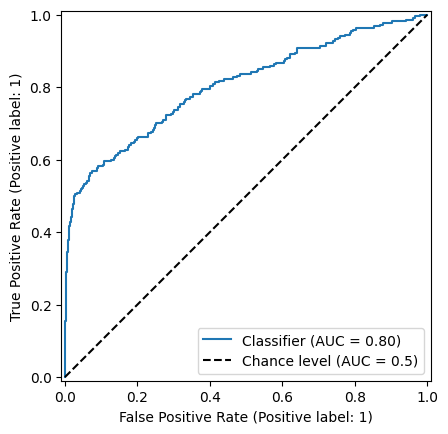

In [9]:
pred_scores = trainer.predict(test_dataset).predictions[:, 1]
RocCurveDisplay.from_predictions(test_dataset['labels'], pred_scores, plot_chance_level=True)
plt.show()